# BO Results Visualization Notebook

Interactive visualization and analysis of Bayesian Optimization experiment results.

## Workflow:
1. **Find Files**: Discover CSV files in specified directory
2. **Convert to JSON**: Convert CSV results to structured JSON format  
3. **Visualize**: Load JSON and create publication-quality plots

Each section can be run independently.

In [7]:
import json
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import glob
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Set style for publication-quality plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("📊 BO Results Visualization Notebook")
print("=" * 50)

📊 BO Results Visualization Notebook


In [8]:
# =============================================================================
# 1. FIND QUALIFIED FILES
# =============================================================================

def find_bo_csv_files(input_directory, pattern="*bo_experiment_results*.csv"):
    """Find all BO CSV files matching pattern in directory"""
    search_path = os.path.join(input_directory, pattern)
    csv_files = glob.glob(search_path)
    
    # Sort by modification time (newest first)
    csv_files.sort(key=os.path.getmtime, reverse=True)
    
    qualified_files = []
    for filepath in csv_files:
        try:
            # Quick validation - check if file has required columns
            df = pd.read_csv(filepath, nrows=5)
            required_cols = ['algorithm', 'iteration', 'best_value', 'regret']
            
            if all(col in df.columns for col in required_cols):
                file_info = {
                    'filepath': filepath,
                    'filename': os.path.basename(filepath),
                    'size_mb': os.path.getsize(filepath) / (1024*1024),
                    'modified': datetime.fromtimestamp(os.path.getmtime(filepath)),
                    'rows': len(pd.read_csv(filepath))
                }
                qualified_files.append(file_info)
            
        except Exception as e:
            print(f"⚠️ Skipping {filepath}: {e}")
    
    return qualified_files

# Configure input directory
INPUT_DIRECTORY = "results/"  # Change this path as needed

print(f"🔍 Searching for BO CSV files in: {INPUT_DIRECTORY}")

if os.path.exists(INPUT_DIRECTORY):
    qualified_files = find_bo_csv_files(INPUT_DIRECTORY)
    
    if qualified_files:
        print(f"\n✅ Found {len(qualified_files)} qualified CSV files:")
        print("-" * 60)
        
        for i, file_info in enumerate(qualified_files):
            print(f"{i+1}. {file_info['filename']}")
            print(f"   Size: {file_info['size_mb']:.2f} MB")
            print(f"   Rows: {file_info['rows']:,}")
            print(f"   Modified: {file_info['modified'].strftime('%Y-%m-%d %H:%M:%S')}")
            print(f"   Path: {file_info['filepath']}")
            print()
        
        # Select most recent file for processing
        selected_file = qualified_files[0]
        print(f"🎯 Selected for processing: {selected_file['filename']}")
        
        # Store selected file path globally
        SELECTED_CSV_PATH = selected_file['filepath']
        
    else:
        print("❌ No qualified CSV files found")
        print("   Make sure the directory contains CSV files with columns: algorithm, iteration, best_value, regret")
        SELECTED_CSV_PATH = None
        
else:
    print(f"❌ Directory not found: {INPUT_DIRECTORY}")
    print("   Please update INPUT_DIRECTORY variable above")
    SELECTED_CSV_PATH = None

🔍 Searching for BO CSV files in: results/

✅ Found 4 qualified CSV files:
------------------------------------------------------------
1. bo_experiment_results_20250814_184047.csv
   Size: 0.02 MB
   Rows: 180
   Modified: 2025-08-14 18:40:48
   Path: results/bo_experiment_results_20250814_184047.csv

2. bo_experiment_results.csv
   Size: 0.02 MB
   Rows: 180
   Modified: 2025-08-14 18:40:47
   Path: results/bo_experiment_results.csv

3. bo_experiment_results_20250814_174122.csv
   Size: 0.07 MB
   Rows: 600
   Modified: 2025-08-14 17:41:24
   Path: results/bo_experiment_results_20250814_174122.csv

4. bo_experiment_results_20250814_173207.csv
   Size: 0.02 MB
   Rows: 180
   Modified: 2025-08-14 17:32:08
   Path: results/bo_experiment_results_20250814_173207.csv

🎯 Selected for processing: bo_experiment_results_20250814_184047.csv


In [9]:
# =============================================================================
# 2. CONVERT CSV TO JSON
# =============================================================================

def csv_to_json_converter(csv_filepath, json_filepath=None):
    """Convert CSV results to structured JSON format"""
    if not os.path.exists(csv_filepath):
        raise FileNotFoundError(f"CSV file not found: {csv_filepath}")
    
    print(f"📄 Loading CSV: {os.path.basename(csv_filepath)}")
    df = pd.read_csv(csv_filepath)
    
    # Generate JSON filepath if not provided
    if json_filepath is None:
        json_filepath = csv_filepath.replace('.csv', '.json')
    
    # Extract metadata from DataFrame
    metadata = {
        'timestamp': datetime.now().isoformat(),
        'source_csv': os.path.basename(csv_filepath),
        'total_experiments': len(df),
        'algorithms': sorted(df['algorithm'].unique().tolist()) if 'algorithm' in df.columns else [],
        'bo_seeds': sorted(df['bo_seed'].unique().tolist()) if 'bo_seed' in df.columns else [],
        'num_bo_runs': len(df['bo_seed'].unique()) if 'bo_seed' in df.columns else 0,
        'ground_truth_best': float(df['ground_truth_best'].iloc[0]) if 'ground_truth_best' in df.columns and len(df) > 0 else None,
        'n_nodes': int(df['n_nodes'].iloc[0]) if 'n_nodes' in df.columns and len(df) > 0 else None,
        'max_iterations': int(df['iteration'].max()) if 'iteration' in df.columns else None,
        'columns': list(df.columns)
    }
    
    # Convert DataFrame to JSON-serializable format
    results_data = {
        'metadata': metadata,
        'results': df.to_dict('records')
    }
    
    # Save JSON file
    with open(json_filepath, 'w') as f:
        json.dump(results_data, f, indent=2)
    
    print(f"✅ JSON saved: {os.path.basename(json_filepath)}")
    print(f"   Total experiments: {metadata['total_experiments']}")
    print(f"   Algorithms: {metadata['algorithms']}")
    print(f"   BO runs: {metadata['num_bo_runs']}")
    print(f"   Graph size: {metadata['n_nodes']} nodes")
    print(f"   Max iterations: {metadata['max_iterations']}")
    
    return json_filepath, metadata

# Convert CSV to JSON if file was selected
if 'SELECTED_CSV_PATH' in globals() and SELECTED_CSV_PATH:
    try:
        json_filepath, conversion_metadata = csv_to_json_converter(SELECTED_CSV_PATH)
        print(f"\n🎉 Conversion completed successfully!")
        
        # Store JSON path for next step
        CONVERTED_JSON_PATH = json_filepath
        
    except Exception as e:
        print(f"❌ Conversion failed: {e}")
        CONVERTED_JSON_PATH = None
        
else:
    print("⚠️ No CSV file selected. Please run the previous cell first.")
    CONVERTED_JSON_PATH = None

📄 Loading CSV: bo_experiment_results_20250814_184047.csv
✅ JSON saved: bo_experiment_results_20250814_184047.json
   Total experiments: 180
   Algorithms: ['random_search', 'sparse_grf']
   BO runs: 3
   Graph size: 100 nodes
   Max iterations: 20

🎉 Conversion completed successfully!
✅ JSON saved: bo_experiment_results_20250814_184047.json
   Total experiments: 180
   Algorithms: ['random_search', 'sparse_grf']
   BO runs: 3
   Graph size: 100 nodes
   Max iterations: 20

🎉 Conversion completed successfully!


🎨 Loading and visualizing: results/bo_experiment_results_20250814_184047.json
📊 Loading JSON: bo_experiment_results_20250814_184047.json
   Loaded 180 experiments
   Algorithms: ['random_search', 'sparse_grf']
   BO runs: 3

📈 Creating convergence plots...


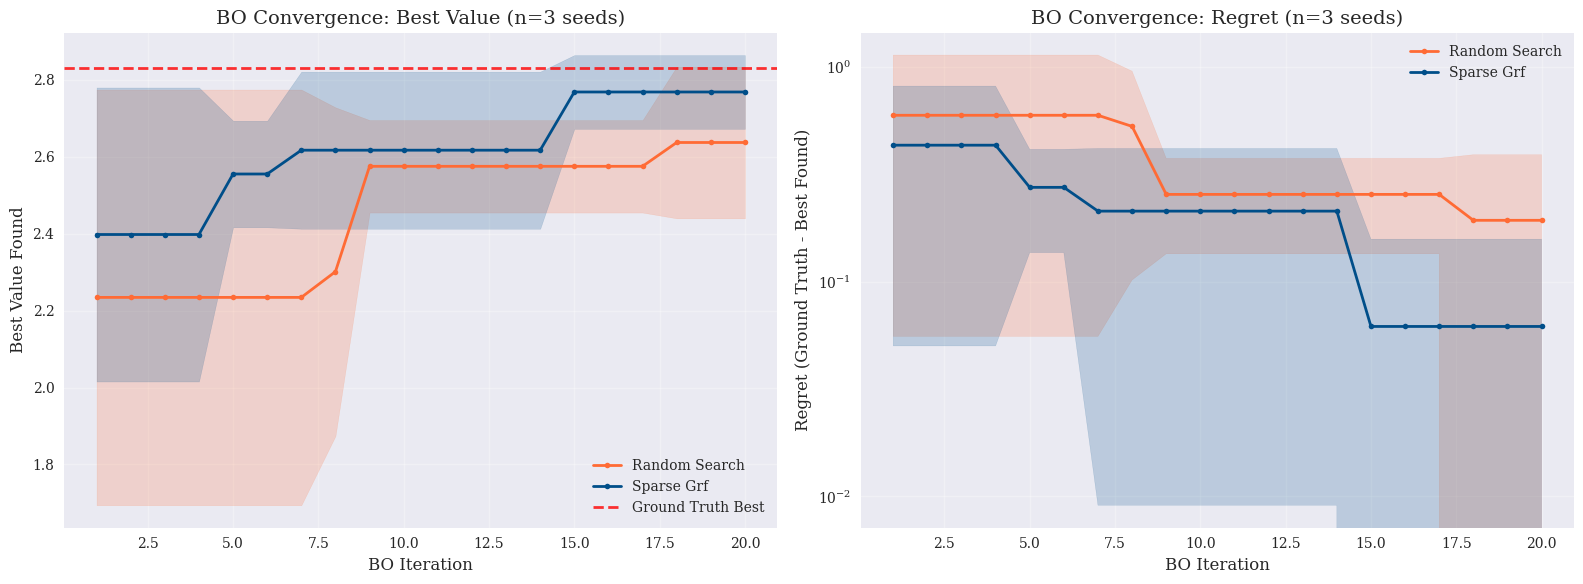


📊 PERFORMANCE ANALYSIS

🔍 Experiment Overview:
   Total experiments: 180
   Graph size: 100 nodes
   Algorithms: random_search, sparse_grf
   BO runs per algorithm: 3
   Ground truth best: 2.8298

📈 Final Performance (Iteration 20):
--------------------------------------------------

RANDOM_SEARCH:
   Best Value: 2.6367 ± 0.1970
   Final Regret: 0.1931 ± 0.1970
   Success Rate (regret < 0.1): 33.3%
   Success Rate (regret < 0.5): 100.0%
   Final dataset size: 30.0 ± 0.0

SPARSE_GRF:
   Best Value: 2.7679 ± 0.0959
   Final Regret: 0.0619 ± 0.0959
   Success Rate (regret < 0.1): 66.7%
   Success Rate (regret < 0.5): 100.0%
   Final dataset size: 50.0 ± 0.0

🎯 Convergence Analysis:
--------------------------------------------------
   random_search: Did not converge (regret >= 0.1)
   sparse_grf: Converged at iteration 15

💾 Plots saved:
   PNG: results/bo_convergence_plot_20250814_194149.png
   PDF: results/bo_convergence_plot_20250814_194149.pdf

✅ Visualization completed successfully!

In [10]:
# =============================================================================
# 3. LOAD JSON AND VISUALIZE
# =============================================================================

def load_json_results(json_filepath):
    """Load results from JSON file and return DataFrame + metadata"""
    if not os.path.exists(json_filepath):
        raise FileNotFoundError(f"JSON file not found: {json_filepath}")
    
    print(f"📊 Loading JSON: {os.path.basename(json_filepath)}")
    
    with open(json_filepath, 'r') as f:
        data = json.load(f)
    
    df = pd.DataFrame(data['results'])
    metadata = data['metadata']
    
    print(f"   Loaded {len(df)} experiments")
    print(f"   Algorithms: {metadata.get('algorithms', [])}")
    print(f"   BO runs: {metadata.get('num_bo_runs', 0)}")
    
    return df, metadata

def create_publication_plots(df, metadata, figsize=(16, 6)):
    """Create publication-quality BO convergence plots"""
    
    # Set publication style
    plt.rcParams.update({
        'font.size': 12,
        'axes.titlesize': 14,
        'axes.labelsize': 12,
        'xtick.labelsize': 10,
        'ytick.labelsize': 10,
        'legend.fontsize': 10,
        'figure.titlesize': 16,
        'font.family': 'serif',
        'text.usetex': False,
        'axes.grid': True,
        'grid.alpha': 0.3
    })
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    
    # Color scheme for algorithms
    colors = {
        'random_search': '#FF6B35', 
        'sparse_grf': '#004E89',
        'dense_grf': '#2F9B69',
        'gp_ucb': '#9B2F68',
        'thompson_sampling': '#8A2BE2'
    }
    
    algorithms = df['algorithm'].unique() if 'algorithm' in df.columns else []
    bo_seeds = df['bo_seed'].unique() if 'bo_seed' in df.columns else [42]
    
    # Plot 1: Best value convergence
    for algorithm in algorithms:
        algo_data = df[df['algorithm'] == algorithm]
        
        if 'iteration' in algo_data.columns and 'best_value' in algo_data.columns:
            mean_values = algo_data.groupby('iteration')['best_value'].mean()
            std_values = algo_data.groupby('iteration')['best_value'].std()
            
            color = colors.get(algorithm, '#000000')
            label = algorithm.replace('_', ' ').title()
            
            # Plot mean line
            ax1.plot(mean_values.index, mean_values.values, 
                    marker='o', color=color, label=f'{label}', linewidth=2, markersize=4)
            
            # Add error bars if multiple runs
            if len(bo_seeds) > 1 and not std_values.isna().all():
                ax1.fill_between(mean_values.index, 
                               mean_values.values - std_values.values,
                               mean_values.values + std_values.values, 
                               color=color, alpha=0.2)
    
    # Add ground truth line
    ground_truth = metadata.get('ground_truth_best')
    if ground_truth is not None:
        ax1.axhline(y=ground_truth, color='red', linestyle='--', 
                   label='Ground Truth Best', linewidth=2, alpha=0.8)
    
    ax1.set_xlabel('BO Iteration')
    ax1.set_ylabel('Best Value Found')
    ax1.set_title(f'BO Convergence: Best Value (n={len(bo_seeds)} seeds)')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Regret convergence
    for algorithm in algorithms:
        algo_data = df[df['algorithm'] == algorithm]
        
        if 'iteration' in algo_data.columns and 'regret' in algo_data.columns:
            mean_regret = algo_data.groupby('iteration')['regret'].mean()
            std_regret = algo_data.groupby('iteration')['regret'].std()
            
            color = colors.get(algorithm, '#000000')
            label = algorithm.replace('_', ' ').title()
            
            # Plot mean line  
            ax2.plot(mean_regret.index, mean_regret.values, 
                    marker='o', color=color, label=f'{label}', linewidth=2, markersize=4)
            
            # Add error bars if multiple runs
            if len(bo_seeds) > 1 and not std_regret.isna().all():
                ax2.fill_between(mean_regret.index,
                               mean_regret.values - std_regret.values,
                               mean_regret.values + std_regret.values,
                               color=color, alpha=0.2)
    
    ax2.set_xlabel('BO Iteration')
    ax2.set_ylabel('Regret (Ground Truth - Best Found)')
    ax2.set_title(f'BO Convergence: Regret (n={len(bo_seeds)} seeds)')
    ax2.set_yscale('log')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    return fig

def print_performance_summary(df, metadata):
    """Print detailed performance analysis"""
    print("\n📊 PERFORMANCE ANALYSIS")
    print("=" * 60)
    
    if 'algorithm' not in df.columns:
        print("❌ No algorithm column found")
        return
    
    # Overall statistics
    print(f"\n🔍 Experiment Overview:")
    print(f"   Total experiments: {len(df)}")
    print(f"   Graph size: {metadata.get('n_nodes', 'Unknown')} nodes")
    print(f"   Algorithms: {', '.join(metadata.get('algorithms', []))}")
    print(f"   BO runs per algorithm: {metadata.get('num_bo_runs', 0)}")
    if metadata.get('ground_truth_best'):
        print(f"   Ground truth best: {metadata.get('ground_truth_best'):.4f}")
    
    # Final performance analysis
    if 'iteration' in df.columns:
        final_iteration = df['iteration'].max()
        final_results = df[df['iteration'] == final_iteration]
        
        print(f"\n📈 Final Performance (Iteration {final_iteration}):")
        print("-" * 50)
        
        for algorithm in sorted(df['algorithm'].unique()):
            algo_final = final_results[final_results['algorithm'] == algorithm]
            
            if len(algo_final) == 0:
                continue
            
            print(f"\n{algorithm.upper()}:")
            
            if 'best_value' in algo_final.columns:
                mean_best = algo_final['best_value'].mean()
                std_best = algo_final['best_value'].std()
                print(f"   Best Value: {mean_best:.4f} ± {std_best:.4f}")
            
            if 'regret' in algo_final.columns:
                mean_regret = algo_final['regret'].mean()
                std_regret = algo_final['regret'].std()
                success_rate_01 = (algo_final['regret'] < 0.1).mean() * 100
                success_rate_05 = (algo_final['regret'] < 0.5).mean() * 100
                
                print(f"   Final Regret: {mean_regret:.4f} ± {std_regret:.4f}")
                print(f"   Success Rate (regret < 0.1): {success_rate_01:.1f}%")
                print(f"   Success Rate (regret < 0.5): {success_rate_05:.1f}%")
            
            if 'dataset_size' in algo_final.columns:
                mean_data = algo_final['dataset_size'].mean()
                std_data = algo_final['dataset_size'].std()
                print(f"   Final dataset size: {mean_data:.1f} ± {std_data:.1f}")
    
    # Convergence analysis
    if 'iteration' in df.columns and 'regret' in df.columns:
        print(f"\n🎯 Convergence Analysis:")
        print("-" * 50)
        
        for algorithm in sorted(df['algorithm'].unique()):
            algo_data = df[df['algorithm'] == algorithm]
            mean_regret_by_iter = algo_data.groupby('iteration')['regret'].mean()
            
            # Find convergence point (regret < 0.1)
            converged_iters = mean_regret_by_iter[mean_regret_by_iter < 0.1]
            if len(converged_iters) > 0:
                convergence_iter = converged_iters.index[0]
                print(f"   {algorithm}: Converged at iteration {convergence_iter}")
            else:
                print(f"   {algorithm}: Did not converge (regret >= 0.1)")

# Load JSON and create visualizations
# You can modify JSON_PATH to load any specific JSON file
JSON_PATH = CONVERTED_JSON_PATH if 'CONVERTED_JSON_PATH' in globals() and CONVERTED_JSON_PATH else "results/bo_experiment_results.json"

print(f"🎨 Loading and visualizing: {JSON_PATH}")

try:
    if os.path.exists(JSON_PATH):
        # Load data
        df, metadata = load_json_results(JSON_PATH)
        
        # Create plots
        print(f"\n📈 Creating convergence plots...")
        fig = create_publication_plots(df, metadata)
        
        # Print analysis
        print_performance_summary(df, metadata)
        
        # Save plots
        output_dir = os.path.dirname(JSON_PATH)
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        
        png_file = os.path.join(output_dir, f'bo_convergence_plot_{timestamp}.png')
        pdf_file = os.path.join(output_dir, f'bo_convergence_plot_{timestamp}.pdf')
        
        fig.savefig(png_file, dpi=300, bbox_inches='tight')
        fig.savefig(pdf_file, bbox_inches='tight')
        
        print(f"\n💾 Plots saved:")
        print(f"   PNG: {png_file}")
        print(f"   PDF: {pdf_file}")
        
        print(f"\n✅ Visualization completed successfully!")
        
    else:
        print(f"❌ JSON file not found: {JSON_PATH}")
        print(f"   Please run previous cells or update JSON_PATH variable")
        
except Exception as e:
    print(f"❌ Visualization failed: {e}")
    import traceback
    traceback.print_exc()